# MINE4201- SR -  Taller 2
## Modelos colaborativos

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Configuración inicial

In [3]:
!pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 10.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3162991 sha256=6a67d0b6b3095bc32a2ec145eeec1632c07d8ee641cc8262b2fd31bb118650f8
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [3]:
import os
import numpy as np
import pandas as pd
from surprise import Reader
from surprise import Dataset
from surprise.model_selection import train_test_split
from surprise import KNNBasic
from surprise import accuracy
import random

#Para garantizar reproducibilidad en resultados
seed = 10
random.seed(seed)
np.random.seed(seed)

In [5]:
# se cargan los datos desde Google Drive
drive_path = '/content/drive/MyDrive/Colab files/recomendacion_files/taller2_recomendacion/'
#dataset_path = drive_path + 'yelp_dataset.tar'

!tar -xzvf '/content/drive/MyDrive/Colab files/recomendacion_files/taller2_recomendacion/yelp_dataset.tar'

Dataset_User_Agreement.pdf
yelp_academic_dataset_business.json
yelp_academic_dataset_checkin.json
yelp_academic_dataset_review.json
yelp_academic_dataset_tip.json
yelp_academic_dataset_user.json


## Carga de datos

No tendremos en cuenta Checkins ni Tips

### Business

In [23]:
business_path = '/content/yelp_academic_dataset_business.json'

df_business = pd.read_json(business_path, lines=True)

display(df_business.head())
df_business.info()
df_business.shape

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",None
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,0,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Department Stores, Shopping, Fashion, Home & G...","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ..."
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2..."


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150346 entries, 0 to 150345
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   business_id   150346 non-null  object 
 1   name          150346 non-null  object 
 2   address       150346 non-null  object 
 3   city          150346 non-null  object 
 4   state         150346 non-null  object 
 5   postal_code   150346 non-null  object 
 6   latitude      150346 non-null  float64
 7   longitude     150346 non-null  float64
 8   stars         150346 non-null  float64
 9   review_count  150346 non-null  int64  
 10  is_open       150346 non-null  int64  
 11  attributes    136602 non-null  object 
 12  categories    150243 non-null  object 
 13  hours         127123 non-null  object 
dtypes: float64(3), int64(2), object(9)
memory usage: 16.1+ MB


(150346, 14)

### User

In [6]:
user_path = '/content/yelp_academic_dataset_user.json'

# se usa un JsonReader para leer el json de a pedazos
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_json.html
df_user_iter = pd.read_json(user_path, lines=True, chunksize=100000) # JsonReader

In [8]:
df_user = pd.DataFrame()

i=1
for df in df_user_iter:
    #df = df[df['business_id'].isin(df_business['business_id'])]
    # se van leyendo 100.000 lineas y se van agregando al df

    selected_columns = ['user_id', 'name']
    df_user = pd.concat([df_user, df[selected_columns]])
    # TODO: solo agregar las dimensiones que vamos a uar
    print(i)
    i+=1
    # segementacion de usuarios
    #if i==10:
    #  break

selected_users = df_user['user_id']

display(df_user.head())
df_user.shape

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


,user_id,name
100000,wjPr1G2xPN8kqO6Rcee5eA,Richard
100001,DyLXpHDgdoONAvkN6Op1BA,Katurah
100002,yg9zQGUzqjPwKJhFTnNm8Q,Katy
100003,9sFm8hp5paha2zUZKjucUg,Jay
100004,EaWda5u5X6wCvkl4c3Skpg,Nita


(1887897, 2)

### Review

In [21]:
review_path = '/content/yelp_academic_dataset_review.json'

# se usa un JsonReader para leer el json de a pedazos
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_json.html
df_review_iter = pd.read_json(review_path, lines=True, chunksize=100000) # JsonReader

In [24]:
df_review = pd.DataFrame()

i=1
for df in df_review_iter:
    # las reviews deben ser de usuarios conocidos
    df = df[df['user_id'].isin(df_user['user_id'])]
    # las reviews deben ser de negocios conocidos
    df = df[df['business_id'].isin(df_business['business_id'])]

    # tomamos reviews recientes (desde 2019 hasta 2022 enero)
    df = df[df['date'].dt.year >= 2019]

    # se van leyendo 100.000 lineas y se van agregando al df
    selected_columns = ['user_id', 'business_id', 'stars', 'date']
    df_review = pd.concat([df_review, df[selected_columns]])
    print(i)
    i+=1


display(df_review.head())
df_review.shape

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69


,user_id,business_id,stars,date
194087,s4sR0rvVOf6iby77xGeyLg,z7em5co2qckbAXoDGXynsA,5,2019-01-04 02:18:09
194089,SRp90x9d2719GOZ_PT-a6A,M0r9lUn2gLFYgIwIfG8-bQ,5,2019-01-06 11:48:21
203215,X71-eKfjEgfSxApe2MtrfQ,TVGuOv0Nc0omLXtGKVOwdQ,1,2019-02-17 17:17:56
204271,jAgaHj1hc7z34PRWPEPEhQ,WLiqfxv_GhFFA5sm878a2w,5,2019-02-11 14:59:40
204275,F8wJVQrOppgOwSXU08mTdA,720J1v3TX-J95cdTJbCpKA,5,2019-02-20 23:03:26


(1857199, 4)

In [25]:
df_review.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1857199 entries, 194087 to 6990278
Data columns (total 4 columns):
 #   Column       Dtype         
---  ------       -----         
 0   user_id      object        
 1   business_id  object        
 2   stars        int64         
 3   date         datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 70.8+ MB


In [26]:
df_review.describe()

,stars,date
count,1.857199e+06,1857199
mean,3.718320e+00,2020-05-22 18:43:06.768745216
min,1.000000e+00,2019-01-01 00:00:21
25%,2.000000e+00,2019-07-27 19:59:27.500000
50%,5.000000e+00,2020-03-16 14:37:36
75%,5.000000e+00,2021-03-27 21:07:24.500000
max,5.000000e+00,2022-01-19 19:48:25
std,1.615647e+00,NaN


Las calificaciones están en el rango correcto (1 a 5). Fechas va del 2005 (febrero) al 2022 (enero)

<Axes: >

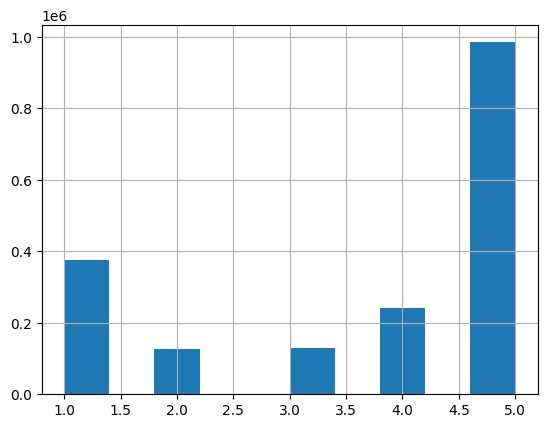

In [27]:
df_review.stars.hist()

Las calificaciones están desbalanceadas, no se distribuyen uniformemente. Verificar la correspondencia con la realidad en este tipo de calificaciones.

In [28]:
display(df_review.useful.value_counts())
print()

display(df_review.funny.value_counts())
print()

display(df_review.cool.value_counts())

AttributeError: 'DataFrame' object has no attribute 'useful'

<Axes: >

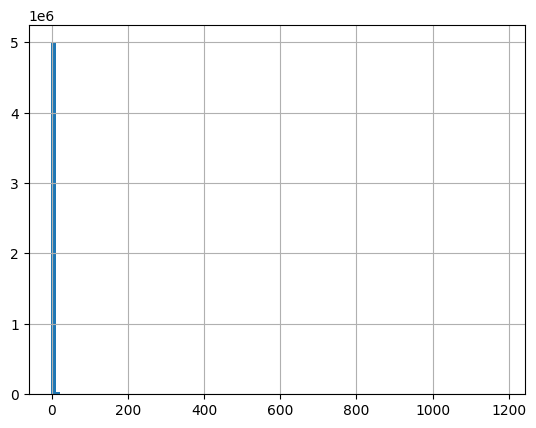

In [15]:
df_review.useful.hist(bins=100)

<Axes: >

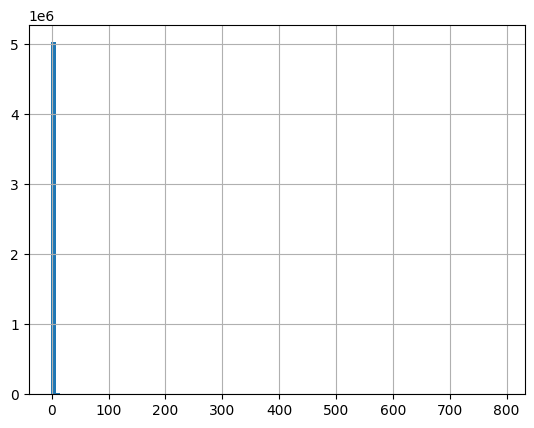

In [16]:
df_review.funny.hist(bins=100)

<Axes: >

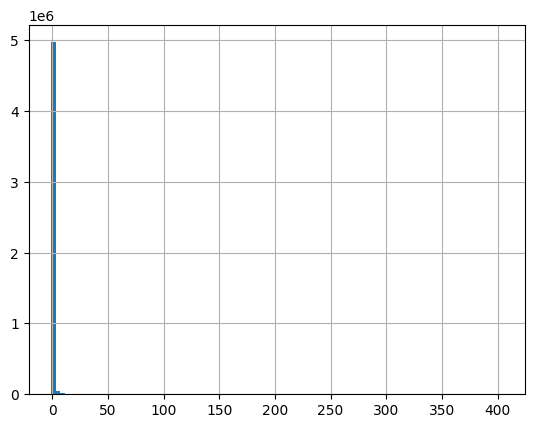

In [17]:
df_review.cool.hist(bins=100)

La mayoría de reviews reciben pocas interacciones, y muy pocas reviews reciben muchas interacciones (son virales)

In [18]:
display(df_review.user_id.value_counts())

user_id
ET8n-r7glWYqZhuR6GcdNw    1653
bJ5FtCtZX3ZZacz2_2PJjA    1298
6s-g2vFu12OemhiK3FJuOQ     888
E4BsVQnG5zetbwv2x8QIWg     780
cufhYFdyrUAt4SWe-m0grQ     742
                          ... 
xDt81BM_hVfJFKBYdQHBeA       1
BDiauYRuPG3kdTTSszLVEg       1
qyxadOAq4lShzijCPKTpXg       1
Abk3IsXReaOL7pW7mdFFYQ       1
_XVdmFWSgTN6YlojUxixTA       1
Name: count, Length: 1879506, dtype: int64

In [ ]:
df_review.user_id.hist()

In [19]:
display(df_review.business_id.value_counts())
df_review.business_id.hist()

business_id
ac1AeYqs8Z4_e2X5M3if2A    6713
_ab50qdWOk0DdB6XOrBitw    6137
GXFMD0Z4jEVZBCsbPf4CTQ    5162
oBNrLz4EDhiscSlbOl8uAw    4555
VQcCL9PiNL_wkGf-uF3fjg    4395
                          ... 
ysorxni_kbHXU5XxvBmyUg       1
-HFXvEB8mBf7jZRd2on-zA       1
eGPVgQpxV-XjMMsO6-2zuw       1
NAlA6hiNlg7mfdLfITyLvw       1
fIkjhTeH2p7L5PTe2hzXEQ       1
Name: count, Length: 149780, dtype: int64

<Axes: >

Error in callback <function _draw_all_if_interactive at 0x7be98c819120> (for post_execute):


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7be98c8183a0> (for post_execute):


KeyboardInterrupt: 

In [ ]:
df_review.head()

df.review.head() ss miércoles 10/04/2024 9:17pm

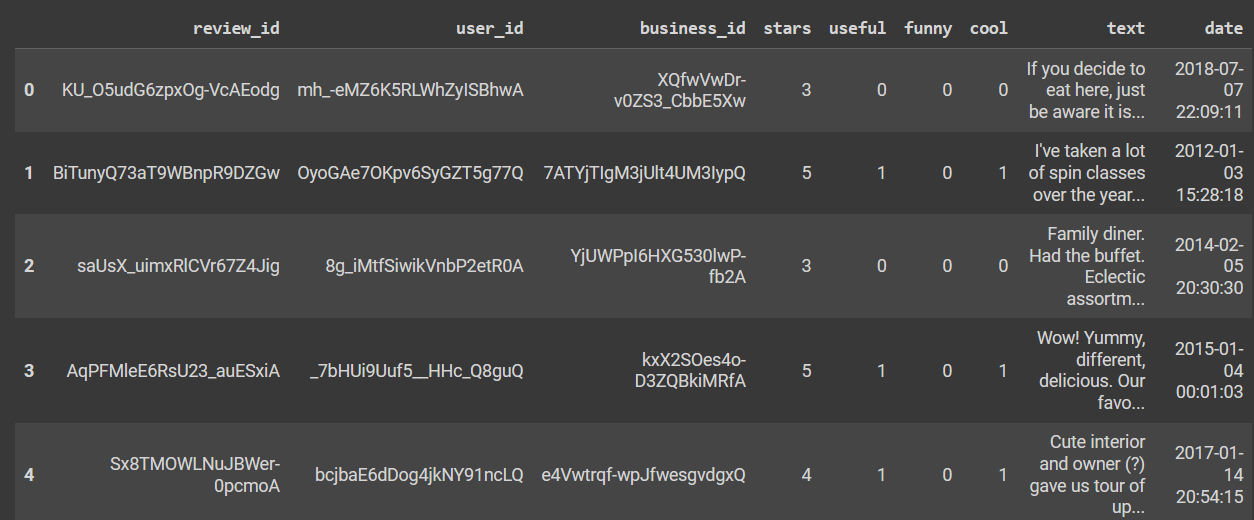

In [ ]:
df_review.tail()

df.review.tail() ss miércoles 10/04/2024 9:17pm

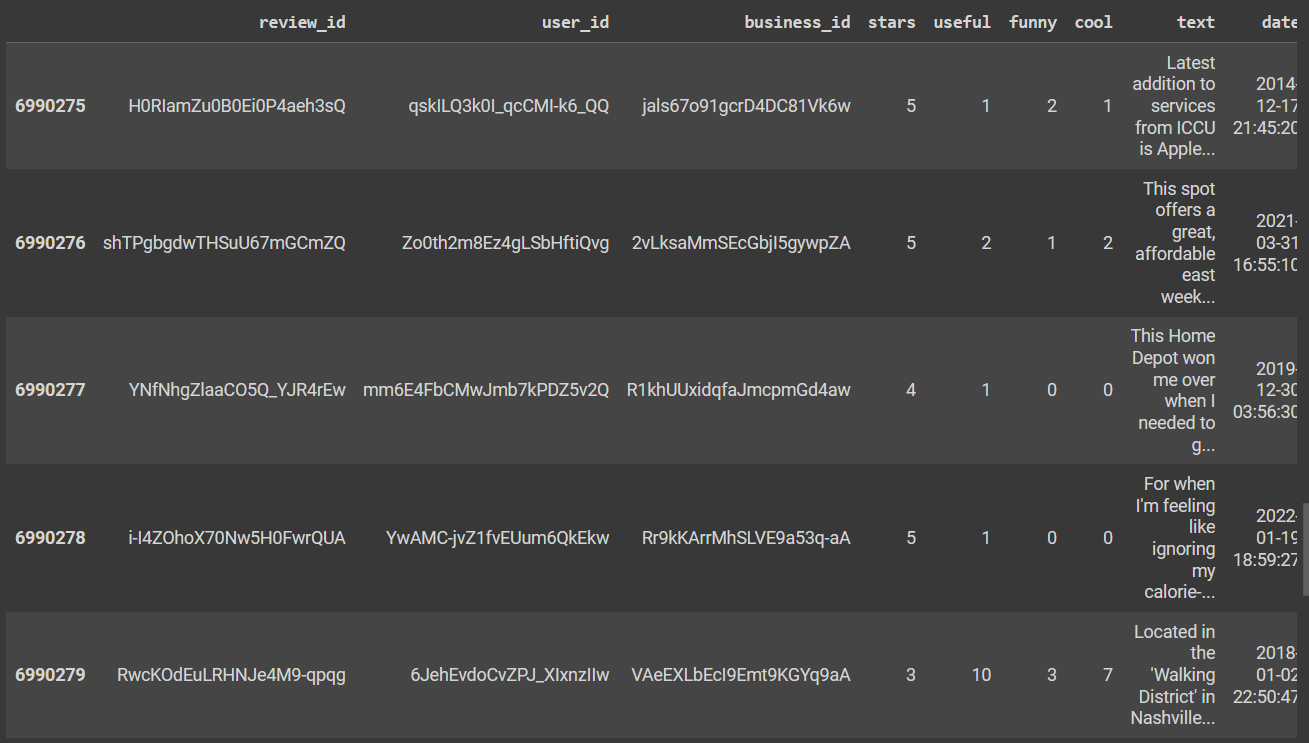

In [ ]:
aaa

## Exploración de datos

### Tabla de interacciones


Modificamos los nombres de las columnas

In [ ]:
path = os.path.join('lastfm-dataset-1K', 'userid-timestamp-artid-artname-traid-traname.tsv')

columns = ['user-id', 'timestamp', 'artist-id', 'artist-name', 'track-id', 'track-name']

# cargamos la columna de de timestamp con formato de fecha
df = pd.read_csv(path, sep='\t', error_bad_lines=False, header=None,
                 names=columns, parse_dates = ['timestamp'])

In [ ]:
df.info()

In [ ]:
df.head()

In [ ]:
df['timestamp'].sort_values()

### Tabla de usuarios

In [ ]:
path_user = os.path.join('lastfm-dataset-1K', 'userid-profile.tsv')

df_user = pd.read_csv(path_user, sep='\t')
df_user.info()
df_user.country.unique()

In [ ]:
selected_countries = ['Colombia', 'Venezuela', 'Peru', 'Chile', 'Argentina']

In [ ]:
selected_users = df_user[df_user['country'].isin(selected_countries)]['#id']
selected_users

print(f'Los usuarios seleccionados son el {round(len(selected_users)/len(df_user)*100,2)}% del total de usuarios y será nuestro mercado objetivo de negocio')

Decisión: Filtraremos solo por usuarios latinos de los países de "Colombia" y "Venezuela" porque se alinea con nuestros objetivos del negocio

In [ ]:
aaaa

## Limpieza y filtrado de datos

Decisión 1: Nos quedamos solo con los registros para el año 2009 a partir de los cuales construiremos el sistema. Esto por diferentes razones: hay suficientes datos para entrenar un modelo (aproximadamente 2.5 M) y para el objetivo de nuestro negocio, es suficiente este año.

In [ ]:
# Filtrar las filas para el año 2008
# 2005 1M
# 2006 4M
# 2007 5M
# 2008 6M
# 2009 2.5M

df = df[df['timestamp'].dt.year == 2008]

In [ ]:
df.info()

In [ ]:
df.head()

Identificamos la cantidad de NaN en las columnas

In [ ]:
df.isna().sum()

Tomamos la decisión de eliminar las fila cuyo artist-id es NaN, puesto que solo representan alreadedor del 3% de las interacciones.

In [ ]:
df = df.dropna(subset=['artist-id'])

In [ ]:
df.isna().sum()

In [ ]:
df.info()

Para el caso de los track-id() con NaN, generamos un hash teniendo en cuenta el artist-id y el track-name que identifique la canción.

In [ ]:
import hashlib

# Función para generar un hash único basado en el nombre de la pista y el id del artista
def generate_unique_id(track_name, artist_id):
    # Convertir a string y codificar para generar un hash
    unique_str = str(track_name) + str(artist_id)
    unique_hash = hashlib.sha256(unique_str.encode()).hexdigest()
    # Podrías acortar el hash si deseas un identificador más corto
    return unique_hash[:16]

# Rellenar NaN en la columna 'track-id' utilizando las columnas 'track-name' y 'artist-id'
df['track-id'] = df.apply(lambda row: generate_unique_id(row['track-name'], row['artist-id']) if pd.isna(row['track-id']) else row['track-id'], axis=1)

In [ ]:
import uuid

# Función para generar un UUID único
def generate_unique_id(track_name, artist_id):
    # No necesitamos combinar el nombre de la pista y el id del artista para generar un UUID
    return str(uuid.uuid4())

# Suponiendo que 'df' es un DataFrame de pandas y tienes las columnas 'track-name', 'artist-id', y 'track-id'
# Rellenar NaN en la columna 'track-id' utilizando la función generate_unique_id
df['track-id'] = df.apply(lambda row: generate_unique_id(row['track-name'], row['artist-id']) if pd.isna(row['track-id']) else row['track-id'], axis=1)

In [ ]:
df.head()

Verificamos que ya no hayan NaNs


In [ ]:
df.isna().sum()

In [ ]:
user_count = df.groupby('user-id')['track-id'].agg({'count'}).sort_values(by='count', ascending=False)
user_count = user_count.reset_index()
user_count

Identificamos fenómeno de cola larga

In [ ]:
import matplotlib.pyplot as plt

user_count['count'].hist()
plt.xlabel('cantidad de interacción')
plt.ylabel('frecuencia de usuarios')
plt.show()

Buscamos obtener un DataFrame con cada 'track-id' único y el número de veces que cada uno aparece en el DataFrame original, ordenado de mayor a menor por este recuento. La variable mt se asigna a este DataFrame resultante.

In [ ]:
# Esto lo usaremos para identificar las pistas más populares en el conjunto de datos, ya que las pistas con más usuarios únicos serían las más populares.
mt = df.groupby('track-id')['user-id'].agg({'count'}).sort_values(by='count', ascending=False)
mt

In [ ]:
#Fenómeno de cola larga por interacciones usuario tracks
mt['count'].hist(bins=100)
plt.xlabel('número de interacciones')
plt.ylabel('frecuencia de interacciones')
plt.title('Fenómeno de cola larga en dataset')
plt.show()

Nos quedamos solo con las columnas user-id y track-id a partir de las cuales construiremos nuestro sistema de recomendación.

In [ ]:
user_track = df[['user-id', 'track-id']]
user_track

In [ ]:
user_track.groupby('track-id')['track-id'].count().sort_values()

In [ ]:
user_track.groupby('track-id')['track-id'].count().sort_values().describe()

In [ ]:
user_track['track-id'].nunique()

Evidenciamos muchas canciones que solo se han escuchado una vez. Ignoraremos estas canciones para reducir la dimensionalidad de la matriz de utilidad.

In [ ]:
track_counts = user_track['track-id'].value_counts()
threshold = 30 # tiene que haber sido escuchada al menos n veces

In [ ]:
user_track = user_track[user_track['track-id'].map(track_counts) >= threshold]

In [ ]:
user_track.groupby('track-id')['track-id'].count().sort_values()

In [ ]:
user_track['track-id'].value_counts().describe()

In [ ]:
user_track['track-id'].nunique()

In [ ]:
user_track['count'] = user_track.groupby(['user-id', 'track-id'])['track-id'].transform('count')
user_track = user_track.drop_duplicates()
user_track

In [ ]:
user_track.sort_values(by='count',ascending=False).head(20)

Identificamos que había un usuario (user_000008) cuya actividad era anormal, puesto que había reproducido más de 15k canciones en un año lo cual no tiene mucho sentido práctco. Lo identificamos como outlier y lo eliminamos del dataset porque además no era representativo para la cantidad de datos que tenemos más sí dañaba la muestra.

In [ ]:
df = df[df['user-id']!='user_000008']
user_count = user_count[user_count['user-id']!='user_000008']
user_track = user_track[user_track['user-id']!='user_000008']

In [ ]:
user_track.sort_values(by='count',ascending=False).head()

In [ ]:
# Filtrar el df para incluir solo usuarios seleccionados previamente
user_track = user_track[user_track['user-id'].isin(selected_users)]
user_track.sort_values(by='count',ascending=False)
user_track.describe()

In [ ]:
user_track['count'].hist(bins=100)
plt.xlabel('número de interacciones')
plt.ylabel('frecuencia de interacciones')
plt.title('Fenómeno de cola larga en dataset')
plt.show()

### Calificación implícita basándonos en las interacciones

Primero, normalizamos las interacciones

In [ ]:
user_track['count_normalized'] = (user_track['count'] - user_track['count'].min()) / (user_track['count'].max() - user_track['count'].min())
user_track.describe()

Vamos a desarrollar un sistema de recomendación basado en clasificación numérica entre 1 y 5. Para ello, primero agruparemos los usuarios y para cada uno sacaremos los percentiles 20, 40, 60 y 80. Luego asignaremos la frecuencia de interaccion con un track al percentil que corresponda (1,2,3,4 o 5).

In [ ]:
def asignar_ranking(df, columna_frecuencia):
    # Calcula los percentiles 20, 40, 60, 80 para cada usuario
    percentiles = df.groupby('user-id')[columna_frecuencia].describe(percentiles=[.2, .4, .6, .8])
    percentiles = percentiles[['20%', '40%', '60%', '80%']].rename(columns={'20%': 'p20', '40%': 'p40', '60%': 'p60', '80%': 'p80'})

    # Inicializar columna de ranking
    df['ranking'] = 0

    # Asignar rankings basados en los percentiles
    for index, row in percentiles.iterrows():
        user_id = index
        p20, p40, p60, p80 = row['p20'], row['p40'], row['p60'], row['p80']

        # Asigna rankings de 1 a 5 basados en los percentiles de frecuencia
        df.loc[(df['user-id'] == user_id) & (df[columna_frecuencia] <= p20), 'ranking'] = 1
        df.loc[(df['user-id'] == user_id) & (df[columna_frecuencia] > p20) & (df[columna_frecuencia] <= p40), 'ranking'] = 2
        df.loc[(df['user-id'] == user_id) & (df[columna_frecuencia] > p40) & (df[columna_frecuencia] <= p60), 'ranking'] = 3
        df.loc[(df['user-id'] == user_id) & (df[columna_frecuencia] > p60) & (df[columna_frecuencia] <= p80), 'ranking'] = 4
        df.loc[(df['user-id'] == user_id) & (df[columna_frecuencia] > p80), 'ranking'] = 5

    return df

# Aplica la función al DataFrame 'user_track' y la columna 'count_normalized'
user_track_ranked = asignar_ranking(user_track, 'count_normalized')

In [ ]:
user_track.describe()

Se puede observar la columna "ranking" con el nivel al que pertenece cada interacción usuario-item.

In [ ]:
user_track

In [ ]:
# ver la cantidad de usuarios y items
num_users = user_track['user-id'].nunique()
num_items = user_track['track-id'].nunique()
print(f'número de usuarios = {num_users}, número de tracks = {num_items}')
print(22*16900)

In [ ]:
user_track.describe()

Este fragmento de código en Python utiliza la biblioteca Surprise para sistemas de recomendación. Primero, se crea un objeto Reader con una escala de calificación de 1 a 5. Luego, se carga el dataset desde un dataframe de pandas llamado user_track, que contiene las columnas 'user-id', 'track-id' y 'ranking'. El 'ranking' representa las calificaciones que asignamos previamente a los tracks por usuario. El resultado es un objeto Dataset de Surprise que se puede utilizar para entrenar un modelo de sistema de recomendación.

In [ ]:
reader = Reader(rating_scale = (1, 5))
#Se crea el dataset a partir del dataframe
surprise_dataset = Dataset.load_from_df( user_track[ ['user-id', 'track-id', 'ranking'] ], reader )

## Experimentación

Vamos a probar variando la métrica de similitud entre Coseno y Pearson, que se encuentran en la librería Surprise. Además, utilizaremos los dos tipos de modelos colaborativos: basado en usuario y en item. Por último, experimentaremos con tres valores de k y tres valores de umbral.

Utilizando cross-validation con un valor de k=2 (número de pliegues), compararemos las métricas RMSE y MAE de los distintos modelos y seleccionaremos el mejor para hacer nuestro modelo de recomendación.

In [ ]:
print(f'Obtendremos {3*3*2} modelos con Coseno y {3*3*2} modelos con Pearson')

### Coseno

In [ ]:
from surprise.model_selection import cross_validate

# Valores de k y threshold para iterar
ks = [4, 8, 12]  # Ejemplo de valores de k
thresholds = [2, 4, 6]  # Ejemplo de valores de threshold

In [ ]:
# Iterar sobre todos los métodos de similitud, valores de k y user/item based
results = []
i = 1

similarity = 'cosine'
for user_based in [True, False]:  # True para user-based, False para item-based
    for k in ks:
        for min_support in thresholds:
            sim_options = {
                'name': similarity,
                'user_based': user_based,
                'min_support': min_support
            }
            model_name = f'user={user_based}, sim_method={similarity}, k={k}, threshold={min_support}'
            print(i, model_name)
            i+=1
            algo = KNNBasic(k=k, sim_options=sim_options)
            # Realizar validación cruzada y guardar los resultados
            # Se usa cross_validation
            cv_results = cross_validate(algo, surprise_dataset, measures=['RMSE', 'MAE'], cv=2, verbose=False)
            print('cv done')
            # Guardar los resultados con los parámetros utilizados
            results.append({
                'model_name': model_name,
                'similarity': similarity,
                'user_based': user_based,
                'k': k,
                'min_support': min_support,
                'rmse': cv_results['test_rmse'].mean(),

                'mae': cv_results['test_mae'].mean()
            })
            print(results[-1])
            print()

10 user=False, sim_method=cosine, k=4, threshold=2
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
cv done
{'model_name': 'user=False, sim_method=cosine, k=4, threshold=2', 'similarity': 'cosine', 'user_based': False, 'k': 4, 'min_support': 2, 'rmse': 1.566076035654027, 'mae': 1.4238594281559753}


13 user=False, sim_method=cosine, k=8, threshold=2
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
cv done
{'model_name': 'user=False, sim_method=cosine, k=8, threshold=2', 'similarity': 'cosine', 'user_based': False, 'k': 8, 'min_support': 2, 'rmse': 1.565440006647099, 'mae': 1.424497954736243}


16 user=False, sim_method=cosine, k=12, threshold=2
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
cv done
{'model_name': 'user=False, sim_method=cosine, k=12, threshold=2', 'similarity': 'cosine', 'user_based': False, 'k': 12, 'min_support': 2, 'rmse': 1.5664152017049005, 'mae': 1.4253633265408503}



### Pearson

In [ ]:
# Iterar sobre todos los métodos de similitud, valores de k y user/item based
results = []
i = 1

similarity = 'pearson'
for user_based in [True, False]:  # True para user-based, False para item-based
    for k in ks:
        for min_support in thresholds:
            sim_options = {
                'name': similarity,
                'user_based': user_based,
                'min_support': min_support
            }
            model_name = f'user={user_based}, sim_method={similarity}, k={k}, threshold={min_support}'
            print(i, model_name)
            i+=1
            algo = KNNBasic(k=k, sim_options=sim_options)
            # Realizar validación cruzada y guardar los resultados
            # Se usa cross_validation
            cv_results = cross_validate(algo, surprise_dataset, measures=['RMSE', 'MAE'], cv=2, verbose=False)
            print('cv done')
            # Guardar los resultados con los parámetros utilizados
            results.append({
                'model_name': model_name,
                'similarity': similarity,
                'user_based': user_based,
                'k': k,
                'min_support': min_support,
                'rmse': cv_results['test_rmse'].mean(),
                'mae': cv_results['test_mae'].mean()
            })
            print(results[-1])
            print()

13 user=False, sim_method=pearson, k=8, threshold=2
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
cv done
{'model_name': 'user=False, sim_method=pearson, k=8, threshold=2', 'similarity': 'pearson', 'user_based': False, 'k': 8, 'min_support': 2, 'rmse': 1.5711759451986893, 'mae': 1.4298265720888699}

16 user=False, sim_method=pearson, k=12, threshold=2
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
cv done
{'model_name': 'user=False, sim_method=pearson, k=12, threshold=2', 'similarity': 'pearson', 'user_based': False, 'k': 12, 'min_support': 2, 'rmse': 1.5708668892285091, 'mae': 1.428253970218262}


Todos los mejores modelos son item-item.

## Selección del modelo

Después de comparar los mejores modelos, tomamos la decisión de optar por el modelo con las siguientes características

13 user=False, sim_method=cosine, k=8, threshold=2

{'model_name': 'user=False, sim_method=cosine, k=8, threshold=2', 'similarity': 'cosine', 'user_based': False, 'k': 8, 'min_support': 2, 'rmse': 1.565440006647099, 'mae': 1.424497954736243}

In [ ]:
print('llega')

In [ ]:
sim_options = {
    'name': 'cosine',
    'user_based': False,
    'min_support': 2
}
model = KNNBasic(k=8, sim_options=sim_options)

Dividimos el dataset en un conjunto de entrenamiento y un conjunto de prueba con una proporción 80-20.

In [ ]:
train_set, test_set = train_test_split(surprise_dataset, test_size=.2)

30.000 interacciones falla

15.000 funciona

Estimo máximo 22.000

In [ ]:
#Se le pasa la matriz de utilidad al algoritmo
model.fit(trainset=train_set)

In [ ]:
test_predictions=model.test(test_set)

In [ ]:
random.sample(test_predictions, 20)

In [ ]:
accuracy.rmse(test_predictions)

### Exportación del modelo

In [ ]:
from surprise.dump import dump, load
dump('/content/drive/MyDrive/Colab files/model', algo=model)

In [ ]:
import gc
import ctypes

# borrar cache
libc = ctypes.CDLL("libc.so.6")
libc.malloc_trim(0)

gc.collect()

## Exportación de datos para el backend

### Tabla user

In [ ]:
!pip install faker
!pip install unidecode

In [ ]:
from faker import Faker
from unidecode import unidecode
import random
import uuid

# Instanciar Faker
fake = Faker(['es_CO', 'es_CL'])

# Seleccionar los usuarios unicos de user_track que aparezcan en df_user. Tomar las filas de estos usuarios en df_user
tabla_user = df_user[df_user['#id'].isin(user_track['user-id'].unique())]
# Crear columna con nombre de usuario
tabla_user['nombre'] = tabla_user['#id'].apply(lambda x: unidecode(fake.name()))
tabla_user.rename(columns={'#id':'user-id'}, inplace=True)
tabla_user['user-id'] = [str(uuid.uuid4()) for _ in range(len(tabla_user))]

tabla_user

In [ ]:
drive_path = os.path.join('drive', 'MyDrive', 'Colab files')
tabla_user.to_csv(os.path.join(drive_path,'tabla_user.csv'), index=False)

### Tabla tracks

In [ ]:
user_track['track-id'] = user_track['track-id'].astype(str)
df['track-id'] = df['track-id'].astype(str)

tabla_track = user_track.groupby('track-id')['track-id'].agg({'count'}).sort_values(by='count', ascending=False).reset_index()

tabla_track = pd.merge(tabla_track, df[['track-id','track-name','artist-id']], on='track-id', how='left').drop_duplicates(['track-id'])
tabla_track

In [ ]:
tabla_track.to_csv(os.path.join(drive_path,'tabla_track.csv'), index=False)

### Tabla artistas

In [ ]:
tabla_artist = pd.merge(tabla_track['artist-id'].drop_duplicates(), df[['artist-id','artist-name']], on='artist-id', how='left').drop_duplicates(['artist-id'])
tabla_artist

In [ ]:
tabla_artist.to_csv(os.path.join(drive_path,'tabla_artist.csv'), index=False)